In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import tensorflow as tf
import numpy as np
import flowpm
from numpy.testing import assert_allclose
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from flowpm import linear_field, lpt_init, nbody, cic_paint
import flowpm.tfpm as tfpm
import flowpm.utils as pmutils

%pylab inline

np.random.seed(0)

bs = 64
nc = 64

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib


In [3]:
#power spectra helper functions
import numpy as np
import numpy

def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    #print(dig.size,xsum.size,len((W * kmag).flat))
    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges


def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    
    #print(field.shape)
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

def pk_func(inputs):
    nc = inputs.shape[1] #assume equal dimensions right now
    ic = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    pkr = pk(tf.squeeze(ic,0),shape = ic.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)
    with tf.Session() as sess:
        pk_out = sess.run((pkr),{ic: inputs})
    return pk_out

# Making Initial Density Field...

In [4]:
initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)

with tf.Session() as sess:
    linear_true = sess.run((initial_conditions))

In [5]:
stages = np.linspace(0.1, 0.3, 1, endpoint=True) ## 0.3 when using lyman alpha forest
ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

# Sample particles
state = flowpm.lpt_init(ic, a0=0.1)   

# Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, nc)         

# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(ic), final_state[0])

pkr_ic = pk(tf.squeeze(ic,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)

pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)
        
with tf.Session() as sess:
    sim, pkr_ic0, pkr_out = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [6]:
from flowpm.kernels import fftk

#setting up prior for model
kvec = fftk((nc, nc, nc), symmetric=False)
kmesh = sum((kk / bs * nc)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """


In [7]:
#variable noise... in this case masking the edges and including variable noise over image

a = numpy.arange(64)
numpy.random.shuffle(a)

noise_prop = np.ones((nc,nc,nc))*0.01
  
inv_sigma = (1/noise_prop)

0.79699224


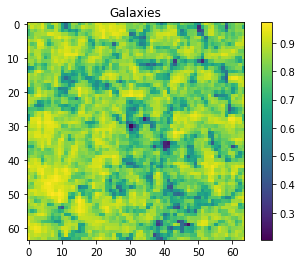

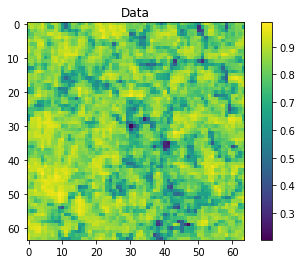

In [8]:
#True Bias Values...
b1=.22
b2=1.8

from scipy import ndimage
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2 = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
gal= np.exp(-b1*sims2**b2)
data = gal + noise_real

print(np.mean(gal))
title("Galaxies")
imshow(gal[0,4])
colorbar()
show()

title("Data")
imshow(data[0,4])
colorbar()

In [9]:
from tensorflow.contrib.opt import ScipyOptimizerInterface
import keras.backend as K
import flowpm

maxiter = 100
gtol=1e-12
sigma=1.0
tf.reset_default_graph()

def pm(lin,b):
  state = flowpm.lpt_init(lin, a0=0.1)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return  final_field, tf.math.exp(-1*(0.20+b[0])*final_field**(b[1]+1.8))#(0.90+0.1*b[0])*final_field + (0.20+0.1*b[1])*final_field**2.0#tf.math.exp(-(0.22+b[0]*0.0001)*final_field**(1.8+b[1]*0.0001))


def likelihood_fn(inputs, b,predictions,inv_sigma = inv_sigma):
  """ Evaluates the data chi-squared function through Fast PM
  """
  _,final_field = pm(predictions[..., 0],b)

  clipped1 = final_field#K.clip(final_field,-25,10) #probably a bad idea!
  clipped2 = inputs[...,0]#K.clip(inputs[...,0],-25,10) #probably a bad idea!
  likelihood = tf.reduce_sum((clipped1-clipped2)**2*inv_sigma**2, 
                              axis=[1, 2, 3])

  return likelihood,final_field

def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """

    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    #data = tf.squeeze(data)
    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

class TARDIS:
    def __init__(self,prior_v = [0.0,0.0]):
        self.prior_v = prior_v
        self.__init__model()
    def __init__model(self):
        self.xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
        self.yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data

        self.bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

        self.linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
        self.initlin_op = self.linearkk.assign(self.xx, name='initlin_op')

        linear_wc = tfpm.r2c3d(self.linearkk, norm=nc**3, name=None)
        linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
        self.linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 

        # Compute the likelihood fn
        self.likelihood,self.final_field = likelihood_fn(tf.expand_dims(self.yy, -1), self.bias, tf.expand_dims(self.linear,-1)) 

        # Compute the prior on field
        prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

        # Compute the prior on the parameters (commented out for now!)
        prior_values = tf.constant(self.prior_v)
        prior_2 = tf.reduce_sum((prior_values-self.bias)**2.0) #rough gaussian prior...

        prior_total = tf.reduce_sum(prior_1)+prior_2

        self.logposterior = tf.reduce_mean(self.likelihood) +  tf.reduce_mean(prior_total)


Using TensorFlow backend.


In [10]:
sess = tf.Session()    

def optimize(T,variable,data,starting_point = np.random.randn(1,nc,nc,nc)):
    opt = ScipyOptimizerInterface(T.logposterior, var_list=variable, method='L-BFGS-B',
                                                    options={'maxiter': maxiter, 'gtol':gtol})
    from scipy import ndimage

    #starting_point = np.random.randn(1,nc,nc,nc)

    sess.run(tf.global_variables_initializer())

    batchsize = 1
    # Initialize gradient descent at random point
    sess.run(T.initlin_op, {T.xx: starting_point});
    st = time.time()
    opt.minimize(sess, {T.yy:data[0:1]})
    print("Total Time:", time.time()-st)

In [11]:
T = TARDIS()

In [12]:
optimize(T,[T.linearkk],data)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 4409739.000000
  Number of iterations: 101
  Number of functions evaluations: 110
Total Time: 25.80132794380188


In [13]:
test, inp, fins, bf = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data[0:1]})

In [14]:
optimize(T, [T.linearkk,T.bias], data, starting_point = inp)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3660510.000000
  Number of iterations: 11
  Number of functions evaluations: 22
Total Time: 10.357026100158691


In [15]:
test, inp_i, fins, bf = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data[0:1]})

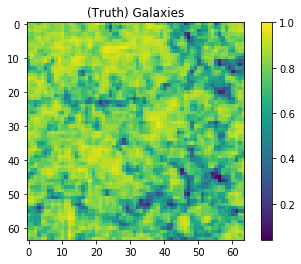

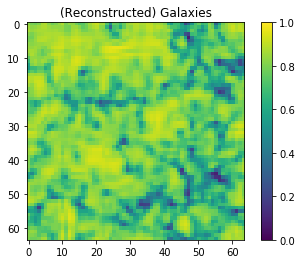

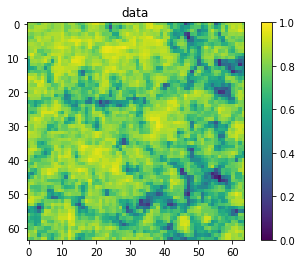

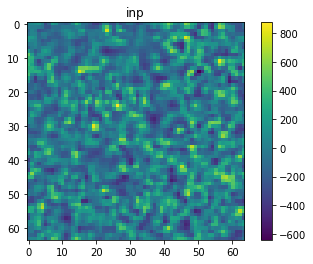

In [16]:

slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow((fins[0][slic]),vmin = 0,vmax = 1)
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp[0,slic])
colorbar()
show()


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.3327734e+03 2.2945413e+02 7.4701973e+01 3.3852669e+01 9.8395081e+00
 2.1298795e+00 4.2131463e-01 8.6148120e-02 1.5362524e-02 2.9320060e-03
 7.1675400e-04 1.7226923e-04]


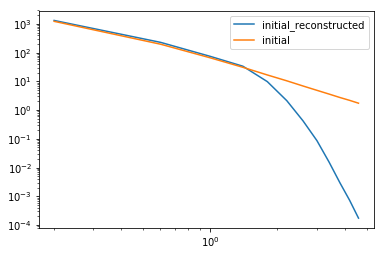

In [17]:
reconstructed_pk = pk_func(test)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

# Lyman-α skewer reconstruction

In [18]:
n_skewers = 1000
snr_min = 100
snr_max = 100
alpha = 2.8
sm = 1.0

def gen_noise(nzpix,n_skewers,snr_min,snr_max,alpha):
        #generates noise according to specified distribution
        snr = numpy.minimum(snr_min/numpy.random.power(alpha-1,size=n_skewers),snr_max)
        skewers_noise = (1.0/snr[:,numpy.newaxis])*numpy.ones(nzpix)
        return snr, skewers_noise

#power law distribution of noise with high snr cutoff
snr, noise_level = gen_noise(nc, n_skewers, snr_min, snr_max, alpha)

In [19]:
# Select skewers
np.random.seed(0)
        
#define indicies with data
x = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
y = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
z = np.arange(0, nc)
        
pos = np.vstack([x,y])
skewers_pos = []
for i in pos.T:
    skewers_pos.append(np.hstack([i*np.ones((nc,2)),z.reshape(1,-1).T]))
    
#final skewer data positions
skewers_fin = np.array(np.vstack(skewers_pos),dtype=int)
        
#flux values at each point 
#### Should be RSD (not sim)
vals_lya = gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()

#if add_ondiag_cont_err:
    # Add estimated error from spectrum continuum fitting to noise variance matrix (but not noise realization).
#    noise_level += continuum_fit_err(snr, nc)

noise_variance = numpy.array([abs(i)*numpy.ones(nc) for i in noise_level]).flatten()
# The inverse covar must be of type float32.
noise_variance = noise_variance.astype(np.float32)
indices = [(i, i) for i in range(len(noise_variance))]
inverse_covar = tf.SparseTensorValue(indices, noise_variance**-1, [len(noise_variance), len(noise_variance)])
       
vals_observed = ndimage.gaussian_filter1d(vals_lya, sm) + n

#if self.add_ondiag_cont_err:
    # Offset flux values if estimated on-diagonal continuum fitting error is added.
    # Assumes each skewer's noise_level array is constant across the skewer.
#    continuum_fit_err_sigma = continuum_fit_err(self.snr, self.universe.nc)
#    for i in range(0, len(self.vals_observed), self.universe.nc):
#        self.vals_observed[i:i + self.universe.nc] /= (1 + np.random.normal(scale=continuum_fit_err_sigma[i // self.universe.nc][0]))

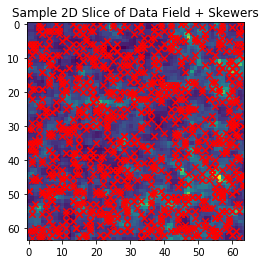

In [20]:
#Plot skewers

title("Sample 2D Slice of Data Field + Skewers")
imshow(sim[0,20,:,:])
plot(skewers_fin[::20][:,0],skewers_fin[::20][:,1],"rx")
show()


In [21]:
#lya_data = vals_observed.reshape((1, 64, 64, 64))
#data = np.exp(-b1*sim**b2)
print(skewers_fin)
#imshow(data[0, 20, :, :], vmin = 0,vmax = 1)

[[35 37  0]
 [35 37  1]
 [35 37  2]
 ...
 [43 32 61]
 [43 32 62]
 [43 32 63]]


(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([ 99.5,  99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3,
        100.4, 100.5]),
 <a list of 10 Patch objects>)

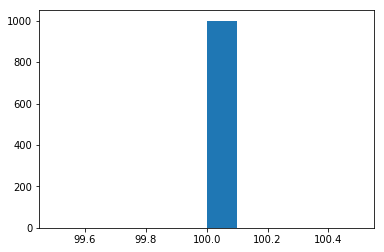

In [22]:
plt.hist(1/noise_level[:,0])

In [23]:
def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def reduce_sum_det(x):
    #deterministic reduce sum
    v = tf.reshape(x, [1, -1])
    return tf.reshape(tf.matmul(v, tf.ones_like(v), transpose_b=True), [])


In [24]:
tf.reset_default_graph()

maxiter = 1000
gtol=1e-12
sigma=1.0

xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
yy_lya = tf.placeholder(tf.float32, [skewers_fin.shape[0]]) #lya flux

bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias


linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linearkk.assign(xx, name='initlin_op')
#evolved_field, evolved_state = uni.pm(self.linear) 

linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 

final_field,evolved_field_FGPA = pm(linear,bias)
# No RSD stuff for now...
#evolved_field_FGPA = K.exp(-1.0*self.RSD_tau)#fgpa(self.evolved_field,bias_lya)
#evolved_field_FGPA = np.exp(-b1*sim2**b2)

# No smoothing for now...
#evolved_field_FGPA_sm = smoothing(evolved_field_FGPA, Rsm, kmesh, nc)
        
flux_val = flowpm.cic_readout(evolved_field_FGPA,np.array(skewers_fin,dtype=np.float32).reshape(1,-1,3))

likelihood = likelihood_fn_lya(flux_val, yy_lya, inverse_covar)
likelihood_lya = reduce_sum_det(likelihood)

# Compute the likelihood fn
#self.likelihood,self.final_field = likelihood_fn(tf.expand_dims(self.yy, -1), self.bias, tf.expand_dims(self.linear,-1)) 

prior_v = [0.0,0.0]

# Compute the prior on field
prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)

# Compute the prior on the parameters (commented out for now!)
prior_values = tf.constant(prior_v)
prior_2 = tf.reduce_sum((prior_values-bias)**2.0) #rough gaussian prior...

prior_total = tf.reduce_sum(prior_1)+prior_2

logposterior = tf.reduce_mean(likelihood_lya) +  tf.reduce_mean(prior_total)

opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})

In [25]:
starting_point = np.random.randn(1, nc, nc, nc) #inp
sess = tf.Session()
sess.run(tf.global_variables_initializer())
batchsize = 1

# Initialize gradient descent at random point
sess.run(initlin_op, {xx: starting_point});

In [26]:
#for r in [0]:
st = time.time()
opt.minimize(sess, {yy_lya:vals_observed})
print("Total Time:", time.time()-st)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52913.648438
  Number of iterations: 788
  Number of functions evaluations: 824
Total Time: 158.81786608695984


In [27]:
#recon_linear, recon_evolved, recon_gal = sess.run([linear, evolved_field, flux_val],
#          {xx:starting_point, yy_lya:vals_observed})
test, inp, fins, bf,flux_out = sess.run([linear,linearkk, final_field,bias,flux_val], {xx:starting_point,yy_lya:vals_observed})

In [32]:
print(bf)

[0. 0.]


In [28]:
skewers_in = vals_observed.reshape(-1,64)
skewers_out = flux_out.reshape(-1,64)
skewers_true = vals_lya.reshape(-1,64)

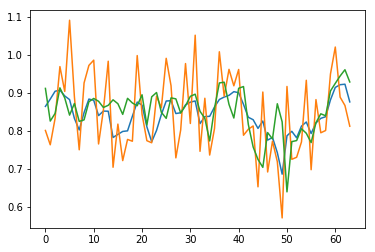

In [29]:
plot(skewers_out[10])
plot(skewers_in[10])
plot(skewers_true[10])

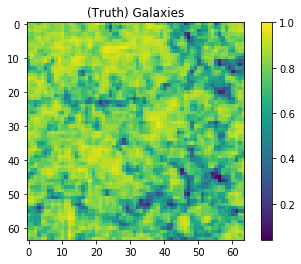

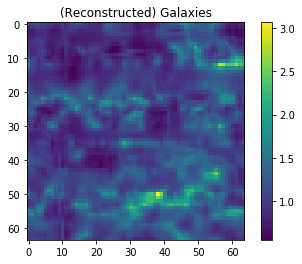

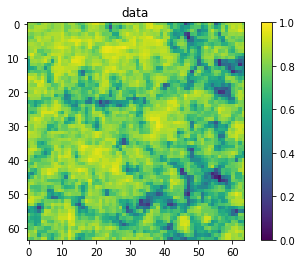

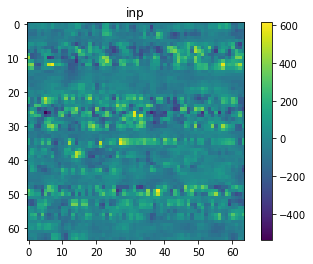

In [30]:

slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow((fins[0][slic]))
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp[0,slic])
colorbar()
show()


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.0706545e+03 1.1745547e+02 2.7456697e+01 7.4178538e+00 2.3899903e+00
 8.6234719e-01 3.3361590e-01 1.2702225e-01 4.4939559e-02 1.6258577e-02
 6.4116241e-03 2.4178675e-03]


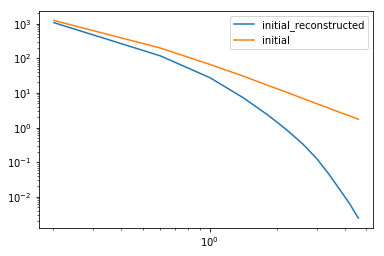

In [31]:
reconstructed_pk = pk_func(test)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

# Injecting power

In [37]:
delta = 0.06
modes = np.linspace(0.01, max(pkr_ic0[0]), reconstructed_pk[0].size)
#print(kmesh[31][31])
#print(max(kmesh[31][31]))

In [38]:
N = modes.size
filts = np.empty(shape=(N,), dtype=object)

for i in range(0, N, 1):
    filts[i] = np.logical_and(kmesh<modes[i]+delta,kmesh>modes[i]-delta)*2 + 1

fisher_matrix = np.zeros((N, N))

In [39]:
reconstructed_extra_power_fields= np.empty(shape=(N,), dtype=object)
true_extra_power_fields = np.empty(shape=(N,), dtype=object)

In [45]:
true_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_bf = np.empty(shape=(N,), dtype=object)
print(reconstructed_initial_mode_pks.shape)
print(N)

(12,)
12


In [49]:
#initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)

#with tf.Session() as sess:
#    linear_true = sess.run((initial_conditions))

def evolve_injected(ic,smwts):
    ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

    datak = tfpm.r2c3d(ic, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)

    # Sample particles
    state = flowpm.lpt_init(dataf, a0=0.1)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, nc)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(dataf), final_state[0])
    pkr_ic = pk(tf.squeeze(dataf,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4) #0.001, 0.05

    pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4) #0.05
        
    with tf.Session() as sess:
        sim_mode, pkr_ic_mode, pkr_out_mode = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})
    return sim_mode, pkr_ic_mode, pkr_out_mode

noise_real_mode = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
 

maxiter = 1000
gtol=1e-12
sigma=1.0
for i in range(0, N, 1):
    tf.reset_default_graph()
    print("N=",i)
    st = time.time()
    
    smwts = filts[i]
    sim_mode, pkr_ic_mode, pkr_out_mode = evolve_injected(ic,smwts)
    #apply transfer function to intial conditions
    true_extra_power_fields[i] = linear_true
    true_initial_mode_pks[i] = pkr_ic_mode
    
    #variable noise... in this case masking the edges and including variable noise over image

    sims2_mode = sim_mode#ndimage.gaussian_filter(sim,0.2,mode="wrap")
    gal_mode= np.exp(-1*b1*sims2_mode**b2)#b1*sims2_mode + b2*sims2_mode**2.0
    data_mode = gal_mode + noise_real_mode
    
    #power law distribution of noise with high snr cutoff
    snr, noise_level = gen_noise(nc, n_skewers, snr_min, snr_max, alpha)
    
    # Select skewers
    np.random.seed(0)
        
    #define indicies with data
    x = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
    y = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
    z = np.arange(0, nc)
        
    pos = np.vstack([x,y])
    skewers_pos = []
    for j in pos.T:
        skewers_pos.append(np.hstack([j*np.ones((nc,2)),z.reshape(1,-1).T]))
    
    #final skewer data positions
    skewers_fin = np.array(np.vstack(skewers_pos),dtype=int)
        
    #flux values at each point 
    #### Should be RSD (not sim)
    vals_lya_mode = gal_mode[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

    #add noise
    n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()

    noise_variance = numpy.array([abs(i)*numpy.ones(nc) for i in noise_level]).flatten()
    # The inverse covar must be of type float32.
    noise_variance = noise_variance.astype(np.float32)
    indices = [(k, k) for k in range(len(noise_variance))]
    inverse_covar = tf.SparseTensorValue(indices, noise_variance**-1, [len(noise_variance), len(noise_variance)])
       
    vals_observed = ndimage.gaussian_filter1d(vals_lya_mode, sm) + n
     
    
    ######## LOOP 1: Just optimize density field
    xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    yy_lya = tf.placeholder(tf.float32, [skewers_fin.shape[0]]) #lya flux

    bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias
    
    linearkk = tf.get_variable('linmeshmode', shape=(1, nc, nc, nc),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
    initlin_op = linearkk.assign(xx, name='initlin_op')
    
    linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
    linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
    linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2)
    
    final_field,evolved_field_FGPA = pm(linear,bias)
    
    flux_val = flowpm.cic_readout(evolved_field_FGPA,np.array(skewers_fin,dtype=np.float32).reshape(1,-1,3))

    likelihood = likelihood_fn_lya(flux_val, yy_lya, inverse_covar)
    likelihood_lya = reduce_sum_det(likelihood)
    
    prior_v = [0.0,0.0]

    # Compute the prior on field
    prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)

    # Compute the prior on the parameters (commented out for now!)
    prior_values = tf.constant(prior_v)
    prior_2 = tf.reduce_sum((prior_values-bias)**2.0) #rough gaussian prior...

    prior_total = tf.reduce_sum(prior_1)+prior_2

    logposterior = tf.reduce_mean(likelihood_lya) +  tf.reduce_mean(prior_total)

    opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})
    
    starting_point = np.random.randn(1, nc, nc, nc) #inp
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    batchsize = 1

    # Initialize gradient descent at random point
    sess.run(initlin_op, {xx: starting_point});
    
    st = time.time()
    opt.minimize(sess, {yy_lya:vals_observed})
    print("Total Time:", time.time()-st)
    #----------------------------------------------------------
    #test, inp_i, fins, bf 
    #test_mode, inp_i, fins_mode, bff = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data_mode[0:1]})    
    
    test_mode, inp_mode, fins_mode, bf_mode,flux_out_mode = sess.run([linear,linearkk, final_field,bias,flux_val], {xx:starting_point,yy_lya:vals_observed})
    
    reconstructed_pk_mode = pk_func(test_mode)
    
    reconstructed_initial_mode_pks[i] = reconstructed_pk_mode
    reconstructed_bf[i] = bf_mode
    
    #fisher_entry = (reconstructed_pk_mode[1] - reconstructed_pk[1])
    
    #fisher_matrix[:,i] = fisher_entry
    
    print(i,time.time()-st)
   # saved_fields[i] = test_mode
    
np.save('initial_reconstructed_w_extra_power_pks_lya', reconstructed_initial_mode_pks)
np.save('initial_true_w_extra_power_pks_lya', true_initial_mode_pks)
np.save('linear_reconstructed_w_extra_power_fields_lya', reconstructed_extra_power_fields)
np.save('linear_true_w_extra_power_fields_lya', true_extra_power_fields)




N= 0


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52929.109375
  Number of iterations: 913
  Number of functions evaluations: 929
Total Time: 181.3771641254425


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


0 187.1043438911438
N= 1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 54300.617188
  Number of iterations: 751
  Number of functions evaluations: 765
Total Time: 153.11598134040833


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


1 158.46359848976135
N= 2
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56494.335938
  Number of iterations: 936
  Number of functions evaluations: 951
Total Time: 188.68696999549866


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


2 193.97636938095093
N= 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 56710.062500
  Number of iterations: 1001
  Number of functions evaluations: 1010
Total Time: 197.03663396835327


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


3 202.29375505447388
N= 4
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 55723.234375
  Number of iterations: 1001
  Number of functions evaluations: 1022
Total Time: 199.89162182807922


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


4 205.3466625213623
N= 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 54850.468750
  Number of iterations: 735
  Number of functions evaluations: 748
Total Time: 147.70980048179626


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


5 153.01597118377686
N= 6
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 54203.273438
  Number of iterations: 1001
  Number of functions evaluations: 1007
Total Time: 196.62631821632385


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


6 201.8980357646942
N= 7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 53581.203125
  Number of iterations: 786
  Number of functions evaluations: 799
Total Time: 158.02686071395874


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


7 163.46261477470398
N= 8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 53129.687500
  Number of iterations: 762
  Number of functions evaluations: 773
Total Time: 152.95251274108887


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


8 158.2392177581787
N= 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52999.835938
  Number of iterations: 794
  Number of functions evaluations: 810
Total Time: 160.79742407798767


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


9 166.08239102363586
N= 10
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 52969.078125
  Number of iterations: 1001
  Number of functions evaluations: 1009
Total Time: 198.2723526954651


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


10 203.5758707523346
N= 11
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 52936.398438
  Number of iterations: 1001
  Number of functions evaluations: 1008
Total Time: 197.51165413856506


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


11 202.84924221038818


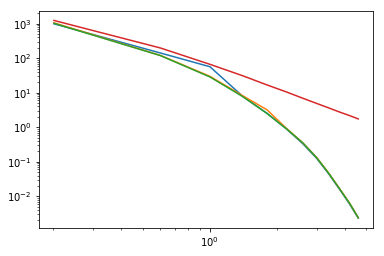

In [60]:
plt.loglog(reconstructed_initial_mode_pks[2][0],reconstructed_initial_mode_pks[2][1])
plt.loglog(reconstructed_initial_mode_pks[4][0],reconstructed_initial_mode_pks[4][1])
plt.loglog(reconstructed_initial_mode_pks[6][0],reconstructed_initial_mode_pks[6][1])
#plt.loglog(reconstructed_pk[0],  reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

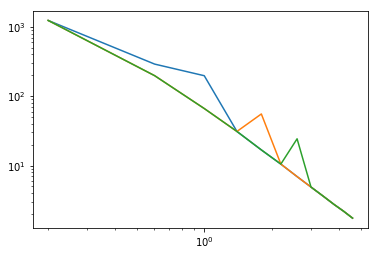

In [61]:
#Input modes, should look like little bumps

#true_initial_mode_pks[i]
plt.loglog(reconstructed_initial_mode_pks[2][0],true_initial_mode_pks[2][1])
plt.loglog(reconstructed_initial_mode_pks[4][0],true_initial_mode_pks[4][1])
plt.loglog(reconstructed_initial_mode_pks[6][0],true_initial_mode_pks[6][1])
#plt.loglog(reconstructed_pk[0],  reconstructed_pk[1], label = 'initial_reconstructed')
#plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

In [62]:
#calculating average reconstructed PS to reduce noise... could also just run the first part of the code a few dozen times...

pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,12,3)]
pk_c = np.median(np.array(pks),axis = 0)


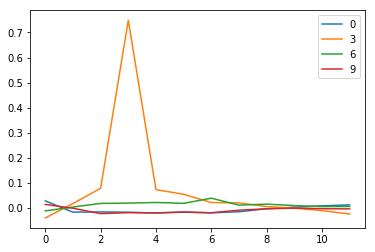

In [63]:
#response of little bumps

for i in range(0,12,3):
    plot(np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:],label=str(i))
legend()
#ylim(-5,5)


In [65]:
print(reconstructed_bf[1])

[0. 0.]


In [319]:

# Add variation to Bias Values
b1_new= b1+delta

# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1_new*sims2_new**b2)
new_data = new_gal + noise_real
######## LOOP 1: Just optimize density field

optimize(T,[T.linearkk],new_data,starting_point =inp)

#test, inp_i, fins, bf 
test_1, inp_1, fins_1, bff_1 = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_data[0:1]})    
print(bff_1)

###### LOOP 2: Optimized Density field + Bias Parameters

optimize(T,[T.linearkk,T.bias],new_data,starting_point =inp_1)

inp_1, test_1, fins_1, bff_1= sess.run([T.linearkk,T.linear, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_data[0:1]})    

print(bff_1)
#########

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 10494363.000000
  Number of iterations: 300
  Number of functions evaluations: 313
Total Time: 67.38731122016907
[0. 0.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2116404.000000
  Number of iterations: 9
  Number of functions evaluations: 22
Total Time: 11.523983240127563
[ 0.08237722 -0.33863366]


In [338]:
b2_new= b2+delta

# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1*sims2_new**b2_new)
new_data = new_gal + noise_real
######## LOOP 1: Just optimize density field

optimize(T,[T.linearkk],new_data,starting_point =inp)

#test, inp_i, fins, bf 
test_2, inp_2, fins_2, bff_2 = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:new_data[0:1],T.yy:new_data[0:1]})    
print(bff)

####### LOOP 2: Optimized Density field + Bias Parameters

optimize(T,[T.linearkk,T.bias],new_data,starting_point =inp_2)

inp_2, test_2, fins_2, bff_2= sess.run([T.linearkk,T.linear, T.final_field,T.bias], {T.xx:new_data[0:1],T.yy:new_data[0:1]})    

print(bff_2)

#########

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1570011.125000
  Number of iterations: 300
  Number of functions evaluations: 315
Total Time: 67.62007021903992
[ 0.02069737 -0.08961742]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 905532.812500
  Number of iterations: 13
  Number of functions evaluations: 25
Total Time: 12.259140014648438
[ 0.02138535 -0.08272958]


In [339]:
reconstructed_bft = np.array([i for i in reconstructed_bf[:]])
bl = [reconstructed_bft[:,0].mean(),reconstructed_bft[:,1].mean()]

In [340]:
bff_1,bff_2

(array([ 0.08237722, -0.33863366], dtype=float32),
 array([ 0.02138535, -0.08272958], dtype=float32))

In [341]:
bl = [reconstructed_bft[:,0].mean(),reconstructed_bft[:,1].mean()]

In [342]:
(bff_1 - bl)/0.06, (bff_2 - bl)/0.06

(array([ 1.0285856, -4.2354193], dtype=float32),
 array([0.01205436, 0.02964872], dtype=float32))

/home/ben.horowitz/flowpm/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/ben.horowitz/flowpm/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.0624722e+03 2.5962570e+02 8.2878098e+01 3.7805466e+01 2.1748205e+01
 1.3124472e+01 5.8181944e+00 1.8768102e+00 4.6775749e-01 1.0995479e-01
 3.0037025e-02 8.7253656e-03]


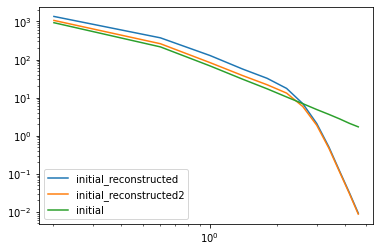

In [343]:
reconstructed_pk = pk_func(test_1)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
reconstructed_pk = pk_func(test_2)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed2')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

[]

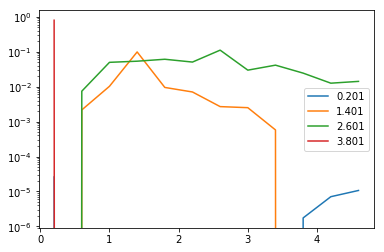

In [67]:
#response of little bumps
#plt.plot(reconstructed_pk[0], np.array(reconstructed_pk[1]-reconstructed_pk_ii[1])[0:]/reconstructed_pk_ii[1]/0.06/3, label = 'initial_reconstructed')

for i in range(0,12,3):
    plot(reconstructed_pk[0],np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:]/pk_c[i],label=str(reconstructed_pk[0][i]))
legend()

semilogy()


In [344]:
np.array(reconstructed_pk[1]-reconstructed_pk_ii[1])[0:]/reconstructed_pk_ii[1]/0.06

array([5.1016569e-01, 8.9094168e-01, 6.9550008e-01, 3.2159412e-01,
       1.6809929e+01, 7.8507896e+01, 1.9916068e+02, 3.3597180e+02,
       4.5636688e+02, 5.4966339e+02, 6.0856885e+02, 6.7766492e+02],
      dtype=float32)

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


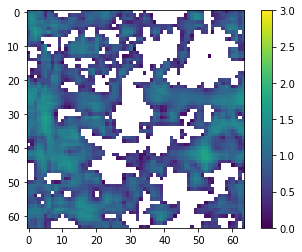

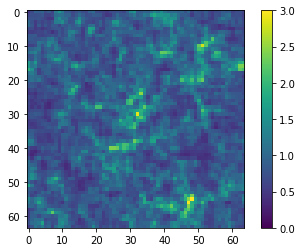

In [68]:
imshow(np.exp((np.log(-1*np.log(fins)/b1)/b2))[0,0],vmax=3,vmin=0)
colorbar()
show()
imshow(sim[0,0],vmax=3,vmin=0)
colorbar()


In [346]:

reconstructed_pk_1 = pk_func(test_1)

reconstructed_pk_2 = pk_func(test_2)



/home/ben.horowitz/flowpm/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


## Calculating terms in FM Calculation...

In [69]:

pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,12,2)]
pk_c = np.median(np.array(pks),axis = 0)



#MODES:

#b_l Eq (4.41)

b_l = pk_c - pkr_ic0[1]

#eq (4.21) and 4.46

#delta theta = pk_c[i]*2

F_ll = np.array([(np.array(reconstructed_initial_mode_pks[i][1]- b_l)/pkr_ic0[1])/(pk_c[i]*2) for i in range(0,N)])


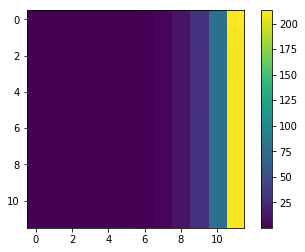

In [70]:
imshow(np.array(F_ll).T)
colorbar()

In [385]:
# Modes x Parameters

reconstructed_bft = np.array([i for i in reconstructed_bf])
b_p = [np.median(reconstructed_bft[:,0]),np.median(reconstructed_bft[:,1])]

F_lp = np.array([(reconstructed_bft[i]-b_p)/(pk_c[i]*2) for i in range(0,N)])


In [386]:
# parameters x modes...

F_pl = [(np.array(reconstructed_pk_1[1]- b_l)/pkr_ic0[1])/0.06,(np.array(reconstructed_pk_2[1]- b_l)/pkr_ic0[1])/0.06,]

F_pp = [(bff_1 - b_p)/0.06, (bff_2 - b_p)/0.06]


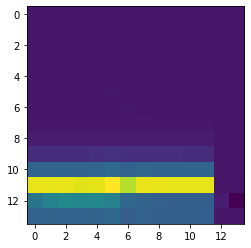

In [387]:
imshow(np.vstack([np.hstack([F_ll,F_lp]),np.hstack([F_pl,F_pp])]))

In [401]:
F_tt = np.vstack([np.hstack([F_ll,F_lp]),np.hstack([F_pl,F_pp])])

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


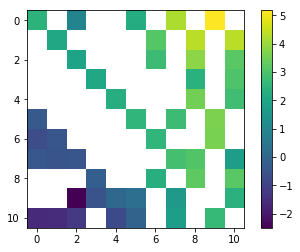

In [71]:
#imshow(np.log10(np.linalg.inv(F_tt[1:,1:].T)))
imshow(np.log10(np.linalg.inv(F_ll[1:,1:].T)))
colorbar()

In [72]:
#1/np.sqrt(np.diag(F_tt))
1/np.sqrt(np.diag(F_ll))

array([44.98459   , 11.256627  ,  6.2738705 ,  3.5873907 ,  2.168224  ,
        1.3178649 ,  0.81672806,  0.50536215,  0.30030403,  0.18005292,
        0.11256251,  0.06890159], dtype=float32)

In [73]:
#np.sqrt(np.diag(np.linalg.inv(F_tt[1:,1:].T)))
np.sqrt(np.diag(np.linalg.inv(F_ll[1:,1:].T)))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


array([16.785593, 11.316088,  9.289099, 11.231336, 13.96714 , 18.622858,
       18.656652, 28.420053, 42.55294 ,       nan,       nan],
      dtype=float32)

In [74]:
#eq 5.3

#derivatives are equal to zero for initial bandpowers, so only matter for forward model parameters

#inverse FGPA
sim_var = np.exp((np.log(-1*np.log(fins)/b1)/b2))
       
new_gal_1= np.exp(-b1*sim_var**b2)

new_gal_2= np.exp(-(b1+delta)*sim_var**b2)

partial_b1 = (new_gal_2-new_gal_1)/delta
                 
                 
new_gal_1= np.exp(-b1*sim_var**b2)

new_gal_2= np.exp(-(b1)*sim_var**(b2+delta))

partial_b2 = (new_gal_2-new_gal_1)/delta
                 
#eq 5.4

res = data- fins

Gl_1 = np.sum(partial_b1 * res*inv_sigma)
Gl_2 = np.sum(partial_b2 * res*inv_sigma)

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [406]:
F_tt[-1,-1] += Gl_2
F_tt[-2,-2] += Gl_1

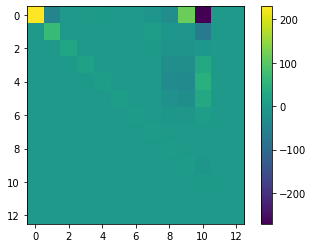

In [407]:
imshow(np.linalg.inv(F_tt[1:,1:].T))
colorbar()

In [75]:
#err_norm = 1/np.sqrt(np.diag(F_tt))
err_norm = 1/np.sqrt(np.diag(F_ll))

In [76]:
#err_marg = np.sqrt(np.diag(np.linalg.inv(F_tt[:,:].T)))
err_marg = np.sqrt(np.diag(np.linalg.inv(F_ll[:,:].T)))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [77]:
for i,_ in enumerate(err_norm):
    print(err_norm[i],err_marg[i])

44.98459 328.26385
11.256627 16.541676
6.2738705 11.365898
3.5873907 9.352613
2.168224 11.224411
1.3178649 13.972415
0.81672806 17.307974
0.50536215 17.968498
0.30030403 33.368866
0.18005292 35.386192
0.112562515 nan
0.06890159 nan


In [413]:
np.std(reconstructed_bft[:,0]),np.std(reconstructed_bft[:,1])

(0.00027275982, 0.010749956)

<ErrorbarContainer object of 3 artists>

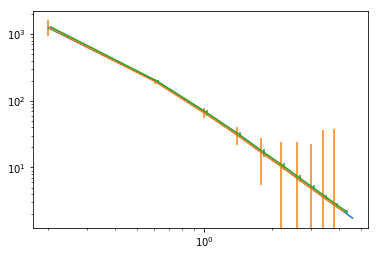

In [111]:


plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1],reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1],yerr=err_marg[:-1])
plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1]*1.03,reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1],yerr=err_norm[:-1])


#After marginalization... small scale error explode!


In [107]:
#err_norm
np.save("lya_err_marg", err_marg)
np.save("lya_true_initial_pk_x",pkr_ic0[0])
np.save("lya_true_initial_pk_y",pkr_ic0[1])
np.save("lya_reconstructed_initial_pk_x", reconstructed_initial_mode_pks[0][0][:-1])
np.save("lya_reconstructed_initial_pk_y", reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1])

[44.98459    11.256627    6.2738705   3.5873907   2.168224    1.3178649
  0.81672806  0.50536215  0.30030403  0.18005292  0.11256251  0.06890159]


<ErrorbarContainer object of 3 artists>

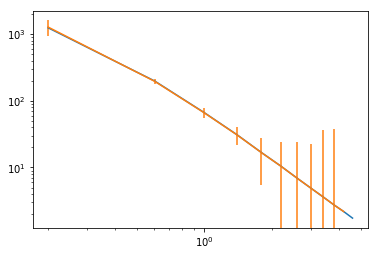

In [108]:
i_x = np.load("lya_true_initial_pk_x.npy")
i_y = np.load("lya_true_initial_pk_y.npy")
r_x = np.load("lya_reconstructed_initial_pk_x.npy")
r_y = np.load("lya_reconstructed_initial_pk_y.npy")
err_marg = np.load("lya_err_marg.npy")
print(err_norm)
plt.loglog(i_x, i_y, label = 'initial')

plt.errorbar(r_x, r_y, yerr=err_marg[:-1])

In [428]:
#covariance matrix for parameters!
np.linalg.inv(F_tt[:,:].T)[-2:,-2:]

array([[ 3.1559616e-06,  2.4645157e-11],
       [-5.0604312e-09,  2.5419306e-04]], dtype=float32)